<a href="https://colab.research.google.com/github/vincebarokie/crypto_model/blob/main/crypto_price_machine_learning_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project - Crypto Price Machine Learning Model

Submitted By: Raymund Vincent Ricabar

**Dataset** is found [here](https://www.kaggle.com/datasets/kaushiksuresh147/top-10-cryptocurrencies-historical-dataset)

This dataset was extracted using web scraping and various python packages like investpy, yahoo finance, pandas data reader.

**TODOS**

- [x] EDA on trending & potential of the Celo (can by any cryptocurrency)
- [ ] Predict prices (close) of Celo (can be any cryptocurrency) 
- [ ] Plot true value and predicted value over time

|No |	Columns	| Descriptions |
|:--|---------|--------------:|
|1	|Date	|Date of the crypto prices|
|2	|Close	|Closing prices of crypto(dollars)|
|3	|Open	|Opening price of crypto on the respective date(Dollars)|
|4	|High	|Highest price of crypto on the respective date(Dollars)|
|5	|Low	|Lowest price of crypto on the respective date(Dollars)|
|6	|Vol.	|Volume of crypto on the respective date(Dollars)|

## Data Cleaning

We will be setting our imports, loading our dataset and perform some initial data exploration in this section.

In [1]:
!pip install -U kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# imports
import pandas as pd
import numpy as np
# config pandas 
pd.options.display.float_format = '{:.5f}'.format

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# import sklearn libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# custom functions
def plot_k_values(data, ks):
  """plot the silhouette score and inertia 
  of a KMeans model for various k values"""

  sils = []
  inertias = []

  for k in ks:
    km = KMeans(n_clusters=k)
    km.fit(data)
    sils.append(silhouette_score(data, km.labels_))
    inertias.append(km.inertia_)
      
    # plot inertia and silhouette score
  fig, ax1 = plt.subplots(figsize=(9,7))
  ax1.set_xlabel('number of clusters')
  ax1.set_ylabel('Inertia', color = 'blue')
  ax1.plot(ks, inertias, color = 'blue',label='inertia',marker ='o')

  ax2 = ax1.twinx()
  
  ax2.set_ylabel('Silhouette Score', color = 'red')
  ax2.plot(ks, sils, color = 'red',label='silhouette score',marker='+')
  ax1.legend(loc=0)  
  ax2.legend(loc='upper left')
  plt.grid()
  plt.show()

In [4]:
# load dataset
df = pd.read_csv('/content/drive/MyDrive/CodingDojo_DS/dataset_files/Celo.csv')
df.head()

,Date,Open,High,Low,Close,Volume,Currency
0,2020-05-22,0.82595,0.97836,0.79553,0.83266,2019357,USD
1,2020-05-23,0.83277,2.51691,0.83277,2.49621,3645282,USD
2,2020-05-24,2.43167,3.91659,1.47054,1.81345,3305900,USD
3,2020-05-25,1.80970,1.93593,1.42681,1.43638,2211306,USD
4,2020-05-26,1.43650,1.94548,1.42443,1.52262,2323976,USD


In [5]:
# check for duplicates and missing values
print(f'Dataset has {df.duplicated().sum()} duplicated rows!')
print('\n')
df.info()

Dataset has 0 duplicated rows!


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 718 entries, 0 to 717
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      718 non-null    object 
 1   Open      718 non-null    float64
 2   High      718 non-null    float64
 3   Low       718 non-null    float64
 4   Close     718 non-null    float64
 5   Volume    718 non-null    int64  
 6   Currency  718 non-null    object 
dtypes: float64(4), int64(1), object(2)
memory usage: 39.4+ KB


This dataset does not have any duplicated rows and no missing values and seems ready for EDA.

In [6]:
# change date column to datetime
df['Date'] = pd.to_datetime(df['Date'])
# drop unecessary columns like currency 
df.drop(columns = 'Currency', inplace = True)
df.head()

,Date,Open,High,Low,Close,Volume
0,2020-05-22,0.82595,0.97836,0.79553,0.83266,2019357
1,2020-05-23,0.83277,2.51691,0.83277,2.49621,3645282
2,2020-05-24,2.43167,3.91659,1.47054,1.81345,3305900
3,2020-05-25,1.80970,1.93593,1.42681,1.43638,2211306
4,2020-05-26,1.43650,1.94548,1.42443,1.52262,2323976


We droped Currency column as it is all USD and will not affect our model in any way. 

In [7]:
# check statistical description
df.describe()

,Open,High,Low,Close,Volume
count,718.00000,718.00000,718.00000,718.00000,718.00000
mean,3.34675,3.57075,3.17913,3.34850,58969239.14345
std,1.43254,1.55643,1.34598,1.43046,107523272.38478
min,0.82595,0.97836,0.79553,0.83266,108462.00000
25%,2.13147,2.25314,2.03205,2.13016,4256353.50000
50%,3.07087,3.20427,2.91980,3.06928,29927592.00000
75%,4.37114,4.69106,4.14329,4.36665,71380718.75000
max,7.61677,10.65836,7.06170,7.63800,1385377430.00000


Mean Price(Close) of Celo is at 3.34 USD and the Volumne 

## Exploratory Data Analysis

We will be performing some initial data visualization in this section.

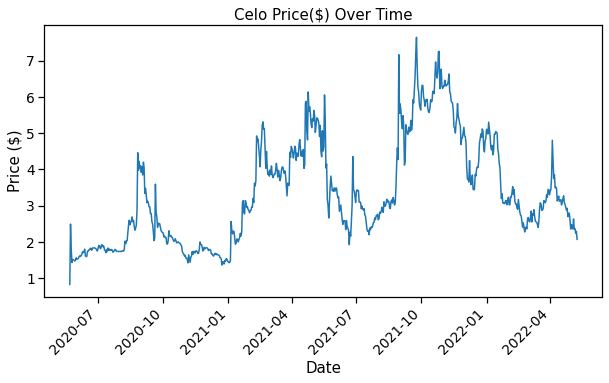

In [8]:
# line plot of crypto price over time
sns.set_context('notebook', font_scale = 1.25)
fig, ax = plt.subplots(figsize = (10, 5))
ax = sns.lineplot(x = df['Date'], y = df['Close'])
ax.set(title = 'Celo Price($) Over Time', ylabel = 'Price ($)')
plt.setp(ax.get_xticklabels(), rotation=45, ha = 'right')
plt.show()

As seen in the visualization above, we can see that Celo Closing Price (applies to all crypto price) is very volatile and could be any price on a given time.

## Visualize as Crypto Trading via Plotly

* Code for this visualization is taken from this [resource](https://pythoninoffice.com/draw-stock-chart-with-python/).

In [9]:
# adding a column indicator 
df['diff'] = df['Close'] - df['Open']
df.loc[df['diff'] >= 0, 'color'] = 'green'
df.loc[df['diff'] < 0, 'color'] = 'red'

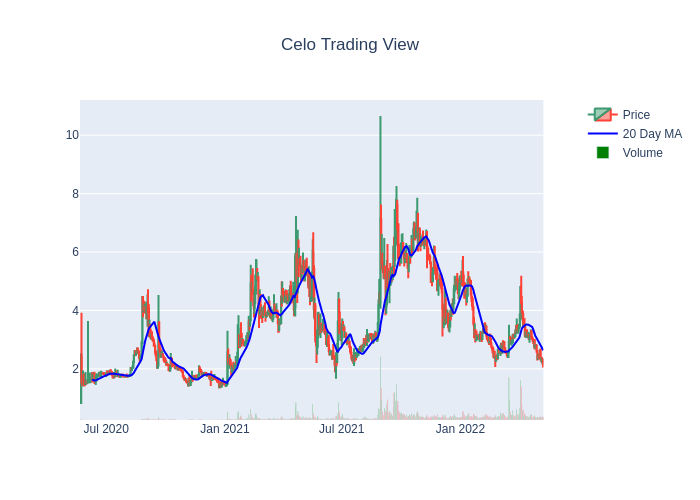

In [11]:
# plot trading view via plotly
fig = make_subplots(specs=[[{"secondary_y": True}]])
# fig.add_trace(go.Scatter(x=df['Date'], y = df['Close'], name = 'Price'), secondary_y = False)
fig.add_trace(go.Candlestick(x = df['Date'], 
                             open = df['Open'], 
                             high = df['High'], 
                             low = df['Low'],
                             close = df['Close'],
                             name = 'Price'
                             ))
fig.add_trace(go.Scatter(x = df['Date'], 
                         y = df['Close'].rolling(window=20).mean(), 
                         marker_color = 'blue', 
                         name = '20 Day MA'
                        ))
fig.add_trace(go.Bar(x=df['Date'], 
                     y = df['Volume'], 
                     name = 'Volume',
                     marker = {'color' : df['color']}
                     ), 
              secondary_y = True
              )
fig.update_yaxes(range = [0, 7000000000], secondary_y = True)
fig.update_yaxes(visible=False, secondary_y = True)
fig.update_layout(title = {'text': 'Celo Trading View', 'x' : 0.5})
# uncomment the line below to disable the range slider
fig.update_layout(xaxis_rangeslider_visible = False)
fig.show("png")

*The visual above is a trading view of the Celo Price (Low, High and Close) daily, and the Volume by day (with green and red indicators). This also includes a 20 Day Moving Average (blue) one indicator that help traders decide whether to buy or sell or hold their assets.*

In [10]:
# save the graph above to html 
fig.write_html(r'/content/drive/MyDrive/CodingDojo_DS/dataset_files/graph.html')

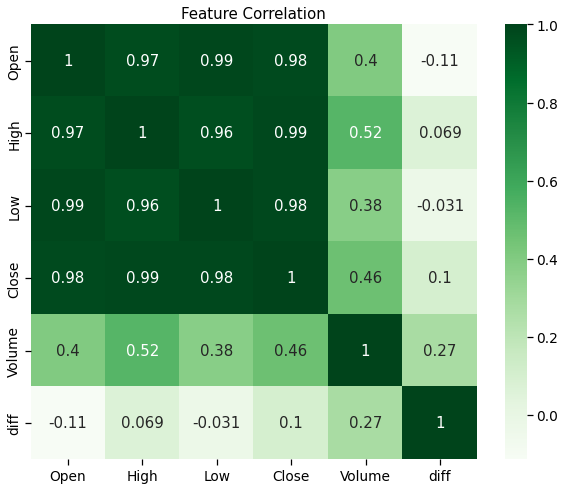

In [11]:
# heatmap plot of dimension correlation
corr = df.corr()
fig, ax = plt.subplots(figsize = (10,8))
sns.heatmap(corr, cmap = 'Greens', annot = True)
ax.set(title = 'Feature Correlation')
plt.show()

Our data shows that prices (Open, Low, High and Closing) are greatly correlated and is also somewhat correlated to our Volume. 

## Applying Feature Engineering on Datetime

We will be adding the following dimensions from the datetime feature
- year
- month (name)
- day of month
- day of week (name)

In [12]:
# feature engineering for datetime dimension
df['year'] = df['Date'].dt.year.astype(str)
df['month (name)'] = df['Date'].dt.month_name()
df['day of month'] = df['Date'].dt.day.astype(str)
df['day of week (name)'] = df['Date'].dt.day_name()
df.drop(columns = 'Date', inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 718 entries, 0 to 717
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Open                718 non-null    float64
 1   High                718 non-null    float64
 2   Low                 718 non-null    float64
 3   Close               718 non-null    float64
 4   Volume              718 non-null    int64  
 5   diff                718 non-null    float64
 6   color               718 non-null    object 
 7   year                718 non-null    object 
 8   month (name)        718 non-null    object 
 9   day of month        718 non-null    object 
 10  day of week (name)  718 non-null    object 
dtypes: float64(5), int64(1), object(5)
memory usage: 61.8+ KB
